In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from gumbel_V6_NS_shGLM import gumbel_NS_shGLM
from sklearn import metrics
import torch.distributions as dist

# Hyperparams

In [2]:
train_T = 65000
test_T = 15000
T_syn = 100
T_hist = 100
C_den = torch.zeros(5,5)
C_den[0,1:] = 1
#C_den = torch.zeros(1).reshape(1,1)
sub_no = C_den.shape[0]

batch_size = 1500

syn_basis_no = 1
hist_basis_no = 1
prop_basis_no = 1


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
#Ensyn = torch.tensor([0+106+213+211+99])
#Insyn = torch.tensor([1+22+36+42+19])
E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]

# Train Params

In [4]:
model = gumbel_NS_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([15000])


In [5]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

In [6]:
repeat_no = 1
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

63500
63500


In [7]:
#optimizer = optim.Adam(model.parameters(), lr=0.00001)
optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.SGD(model.parameters(), lr=0.0004, momentum=0.9)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)


348


In [8]:
#batch_no = 10000
loss_array = np.empty((batch_no//100, 2))

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
        
    diff = (batch_ref - batch_pred) ** 1
    var_loss = torch.var(diff)

    
    loss = var_loss
    #print(i, var_loss.item(), torch.mean(batch_spikes).item())

        
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        #print(torch.mean(test_spikes, 0).cpu().detach().numpy())
        #print(torch.mean(spike_probs, 0).cpu().detach().numpy())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/cont_shglm/histGLMmono_L23_sub5_b4_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/cont_shglm/histGLMmono_L23_sub5_b4_test_scores.npy", loss_array)


<ipython-input-8-c2bca97ec93f>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 40.09320922309782 0.00554534385479899 0.004240785970984873
TEST 50 36.63306604837097 0.09136924161248616 0.0710733041157754
TEST 100 34.02721455711773 0.15600365720303877 0.17811448965008903
TEST 150 32.009844260125845 0.20604163925575258 0.2032899988332455
TEST 200 29.3565415602674 0.2718530142468242 0.2467223590468497
TEST 250 28.96614870846303 0.28153615004819355 0.22259826182733955
TEST 300 25.812184497112852 0.35976571693536197 0.3077441929101614
TEST 350 26.9618528906918 0.33124983826863064 0.35974363857063574
TEST 400 24.87120887295009 0.3831052701832458 0.3834274198474653
TEST 450 23.440507264134688 0.4185917754024451 0.43593349069203147
TEST 500 22.688606977625263 0.43724158558519866 0.4851760810484782
TEST 550 21.41489839307956 0.46883410353671584 0.4933827448734437
TEST 600 21.753445397499775 0.4604369298348112 0.5390681024110066
TEST 650 19.877071225738423 0.5069777047019244 0.5344947350615774
TEST 700 18.392178703192887 0.5438083378408369 0.5374471697915721
TEST 750

TEST 6250 4.492924634650151 0.8885594365977024 0.8325311920205387
TEST 6300 4.447832292638093 0.8896778875914205 0.8488936259756987
TEST 6350 4.363740773103128 0.8917636573457544 0.8820619048824735
TEST 6400 4.2153760674635254 0.8954436314643522 0.8279330658421535
TEST 6450 4.831051462977332 0.8801726846945723 0.7940885583036477
TEST 6500 4.4506449060001145 0.8896081247448044 0.900166862653591
TEST 6550 4.4504978870584235 0.8896117713223609 0.7866284280840103
TEST 6600 4.463410002793428 0.8892915047901516 0.8895179329834505
TEST 6650 4.787800705244294 0.88124545783662 0.8919815401425667
TEST 6700 4.34418309444455 0.8922487575735591 0.815316688593858
TEST 6750 4.236954707736434 0.8949084041890862 0.9209772339322417
TEST 6800 4.439263036226413 0.8898904357400294 0.8157656810307868
TEST 6850 4.142746374948118 0.8972451070091987 0.8773596988564901
TEST 6900 4.362022728187136 0.8918062710066389 0.8607549038565931
TEST 6950 4.130890673727778 0.8975391706984334 0.7869711874946916
TEST 7000 4.

TEST 12450 3.779174563548822 0.9062629853147234 0.8902515543080531
TEST 12500 3.842057869311134 0.9047032549490915 0.7393684200972488
TEST 12550 3.681488435921808 0.9086859498674598 0.8836331290545689
TEST 12600 3.7263680654427924 0.9075727748929417 0.8686872102340879
TEST 12650 3.832635020947507 0.9049369752079264 0.8683351000727918
TEST 12700 3.731653259189309 0.9074416832381664 0.8899403178980109
TEST 12750 3.693752948561283 0.9083817461747815 0.8708383151777112
TEST 12800 3.967484439891908 0.9015922284169964 0.8841124640964186
TEST 12850 3.943525953730439 0.9021864843729107 0.9050526061015531
TEST 12900 3.7203398464590136 0.9077222962374608 0.851652351532028
TEST 12950 3.829230581048634 0.9050214174649032 0.8536063425676559
TEST 13000 3.906128266902843 0.9031140804683738 0.8736464872379005
TEST 13050 3.6669232949397026 0.9090472173311762 0.9001281619850313
TEST 13100 3.6834617889383012 0.9086370036680794 0.8632830076249938
TEST 13150 3.7039937877434492 0.9081277368442263 0.91222644

TEST 18600 3.5560538723451165 0.9117971746388143 0.9122001245715317
TEST 18650 3.6184173721435386 0.9102503373186988 0.8406101796535009
TEST 18700 3.735784357936189 0.9073392172487008 0.8288162020789651
TEST 18750 3.5967251069972517 0.9107883828885729 0.8572090599407571
TEST 18800 3.598301308194448 0.9107492874736043 0.879786973916902
TEST 18850 3.6673460101182 0.9090367325006077 0.8242934311236157
TEST 18900 3.5835042991422883 0.911116306100555 0.8867111944017279
TEST 18950 3.602851318091391 0.9106364309940903 0.8517282723378049
TEST 19000 3.564668364289841 0.9115835044958293 0.8745882022746327
TEST 19050 3.6456083258418723 0.9095759046342794 0.8906657675879416
TEST 19100 3.525739395487623 0.9125490818300155 0.8585124663541229
TEST 19150 3.6954514236697853 0.9083396179503185 0.8645809364961621
TEST 19200 3.5557166482942706 0.9118055389907037 0.8411811982500672
TEST 19250 3.5874091906985868 0.9110194508559152 0.8713996310048805
TEST 19300 3.5771000361951244 0.9112751546705016 0.8817095

KeyboardInterrupt: 

(0.85, 1.0)

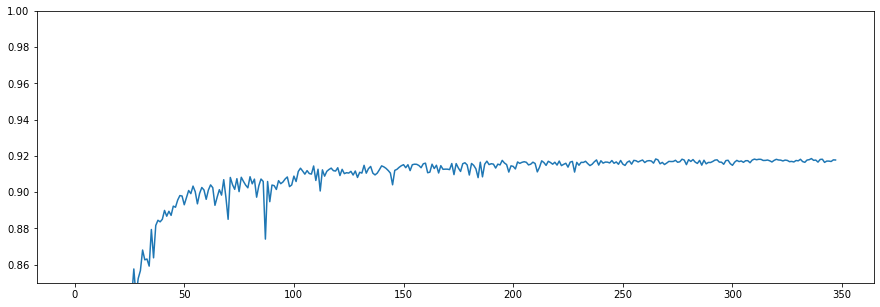

In [9]:
plt.figure(figsize = (15,5))
plt.plot(loss_array[:348,1])
plt.ylim(0.85,1)

# Test 

In [5]:
model = gumbel_NS_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/histGLMmono_L23_sub5_b4_i20200.pt"))
model = model.float().to("cuda")

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()

0.9581151007792877


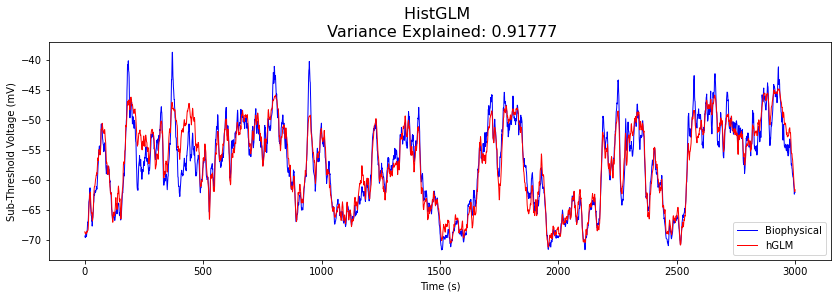

In [22]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[5000:8000], label="Biophysical", c="blue", linewidth=1)
plt.plot(test_V_final[5000:8000]-12,label="hGLM", c="red", linewidth=1)
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("HistGLM \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/cont_shglm/histGLM_L23_sub5_b4.png", dpi=150, bbox_inches='tight')#

In [6]:
np.save("/media/hdd01/sklee/cont_shglm/histglm_L23_sub5_b4_test.npy", test_V_final)

In [10]:
hist_weights= model.hist_weights
hist_bases = model.hist_bases
hist_prod= torch.matmul(hist_weights, hist_bases).cpu().detach().numpy()
for i in range(hist_prod.shape[0]):
    hist_prod[i] /= np.max(np.abs(hist_prod[i]))
    hist_prod[i] = np.flip(hist_prod[i])

In [12]:
#np.save("/media/hdd01/sklee/cont_shglm/histglm_L23_sub5_b4_hist_kern.npy", hist_prod)

In [6]:
tau = model.Tau_syn.cpu().detach().numpy()
delta = model.Delta_syn.cpu().detach().numpy()
weights = model.W_syn.cpu().detach().numpy()

e_kern = np.zeros((sub_no, T_syn))
i_kern = np.zeros((sub_no, T_syn))

t = np.arange(T_syn)
for s in range(sub_no):
    t_e = t - delta[s,0]
    t_i = t - delta[s,1]
    t_e[t_e < 0.0] = 0.0
    t_i[t_i < 0.0] = 0.0
    for b in range(syn_basis_no):
        t_tau_e = t_e / np.exp(tau[b,0])
        t_tau_i = t_i / np.exp(tau[b,1])
        
        part_e_kern = t_tau_e * np.exp(-t_tau_e)
        part_i_kern = t_tau_i * np.exp(-t_tau_i)
        
        e_kern[s] += part_e_kern * weights[s,b,0]
        i_kern[s] += part_i_kern * weights[s,b,1]
        
for s in range(sub_no):
    e_kern[s] /= np.max(np.abs(e_kern[s]))
    i_kern[s] /= np.max(np.abs(i_kern[s]))

In [43]:
#np.save("/media/hdd01/sklee/cont_shglm/histglm_L23_sub5_b4_e_kern.npy", e_kern)
#np.save("/media/hdd01/sklee/cont_shglm/histglm_L23_sub5_b4_i_kern.npy", i_kern)